In [282]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import os

## Template matching y descriptores
Objetivos:
1. Obtener una detección del logo en cada imagen sin falsos positivos
2. Plantear y validar un algoritmo para múltiples detecciones en la imagen `coca_multi.png` con el mismo template del ítem 1
3. Generalizar el algoritmo del ítem 2 para todas las imágenes

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

### Template e imagenes a analizar

In [283]:
TEMPLATE_PATH = "./template/pattern.png"
IMAGES_PATH = "./images/"

template_color = cv2.imread(TEMPLATE_PATH, cv2.IMREAD_COLOR)
images_color = [
    cv2.imread(IMAGES_PATH + image_name, cv2.IMREAD_COLOR)
    for image_name in os.listdir(path=IMAGES_PATH)
    if not "multi" in image_name
]

### Pre-procesamiento de imagenes
<!-- - Se normaliza la imagen mediante una ecualización del histograma -->
- Conversión a escala de grises
- Aplicación de Gaussian Blue para reducción de ruido
- Detección de límites con Canny (no utilizado)

In [284]:
def preprocess_image(input_image: np.ndarray) -> np.ndarray:
    """Encapsulates the pre-processing on images"""
    gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 1)
    # edges_image = cv2.Canny(gray_image, threshold1=50, threshold2=150)
    return blurred_image

Al experimentar, dado que no se obtenían buenos resultados, se intentó recortar los lados del template para compensar la deformación del envase. Este paso como pre-procesamiento fue el que permitió obtener resultados válidos con template matching.

Text(0.5, 1.0, 'Pre-processed template 4')

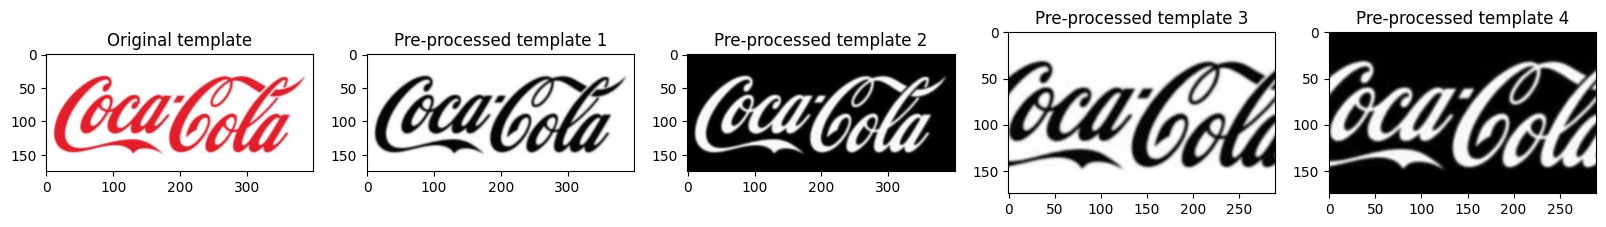

In [285]:
fig, axs = plt.subplots(nrows=1, ncols=5)
fig.set_size_inches(20, 5)
template1 = preprocess_image(template_color)
template2 = -preprocess_image(template_color)
template3 = template1[:,50:340]
template4 = template2[:,50:340]
axs[0].imshow(cv2.cvtColor(template_color, cv2.COLOR_BGR2RGB))
axs[1].imshow(template1, cmap="gray")
axs[2].imshow(template2, cmap="gray")
axs[3].imshow(template3, cmap="gray")
axs[4].imshow(template4, cmap="gray")
axs[0].set_title("Original template")
axs[1].set_title("Pre-processed template 1")
axs[2].set_title("Pre-processed template 2")
axs[3].set_title("Pre-processed template 3")
axs[4].set_title("Pre-processed template 4")

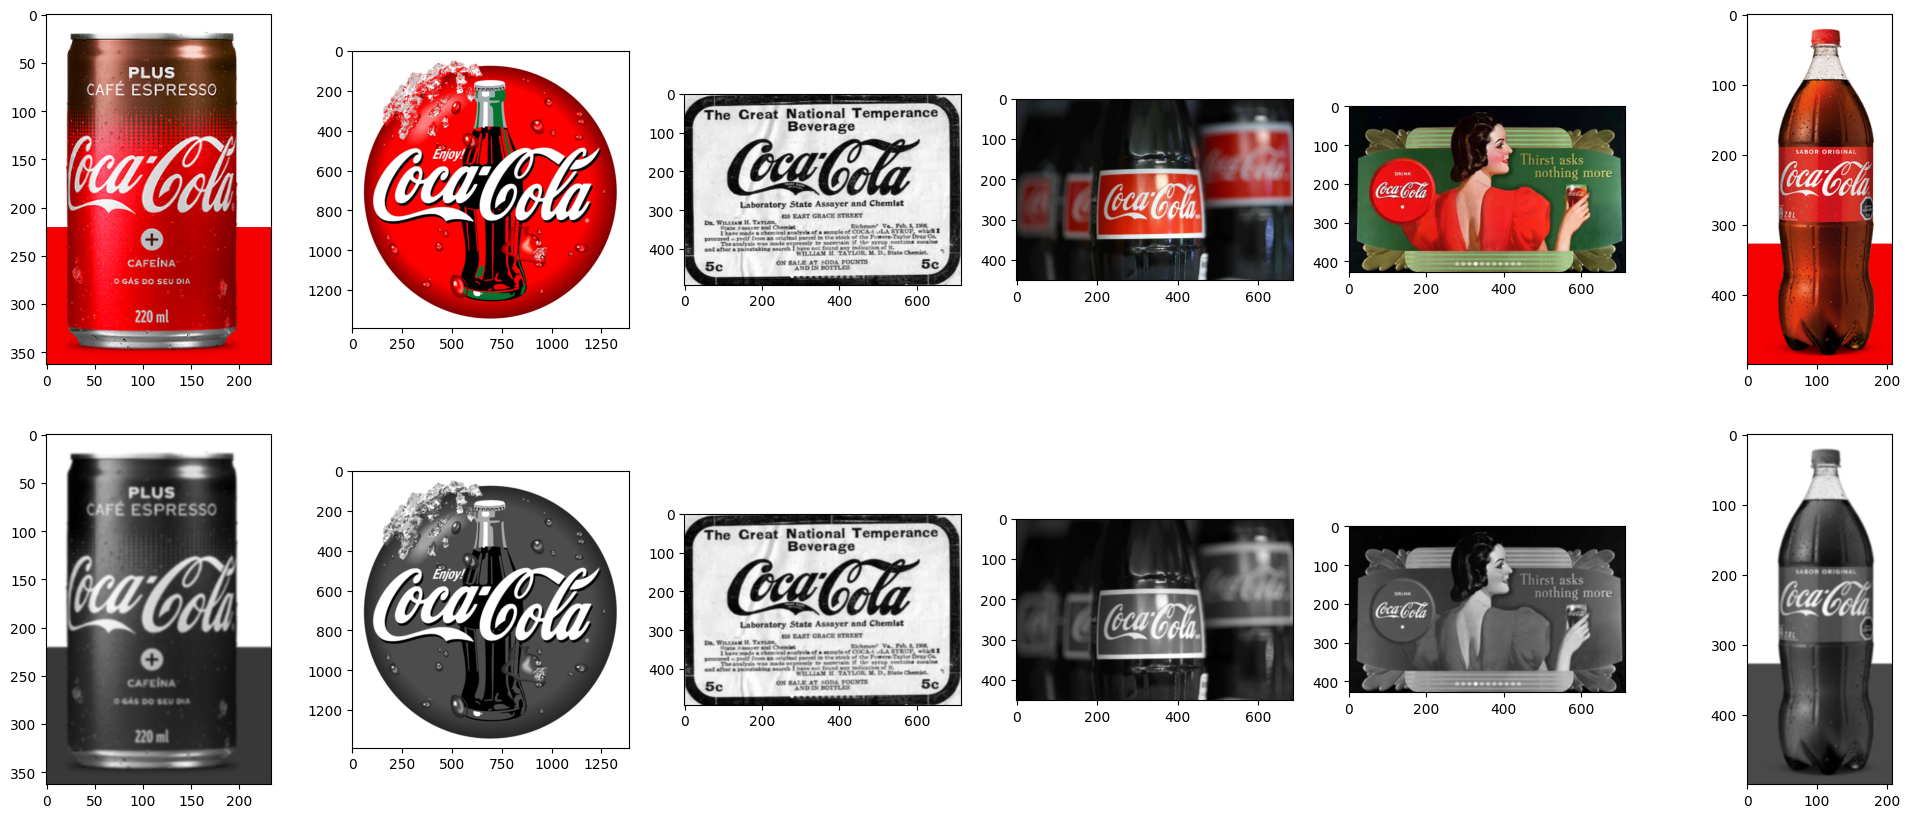

In [286]:
input_images = [preprocess_image(image) for image in images_color]

fig, axs = plt.subplots(nrows=2, ncols=len(images_color))
fig.set_size_inches(25, 10)
for ax_color, ax_preprocess, image_color, input_image in zip(
    axs[0][:], axs[1][:], images_color, input_images
):
    ax_color.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
    ax_preprocess.imshow(input_image, cmap="gray")

### Aplicación de pirámides en el template
Se exploro su uso pero no es utilizado en el algoritmo final.

Piramide gaussiana:

In [287]:
# Get max width and height of the images to test
max_height = max([image.shape[0] for image in input_images])
max_width = max([image.shape[1] for image in input_images])
min_width = 70

# over-sampling
template_oversapling = [template2.copy()]
while (template_oversapling[-1].shape[0] < max_height) and (
    template_oversapling[-1].shape[1] < max_width
):
    template_oversapling.append(cv2.pyrUp(template_oversapling[-1]))
template_oversapling.reverse()
# sub-sampling
template_subsapling = [template2.copy()]
while template_subsapling[-1].shape[1] > min_width:
    template_subsapling.append(cv2.pyrDown(template_subsapling[-1]))
# to not repeat the original
template_gauss_pyramid =  template_oversapling[:-1] + template_subsapling

NUMBER OF TEMPLATES: 6


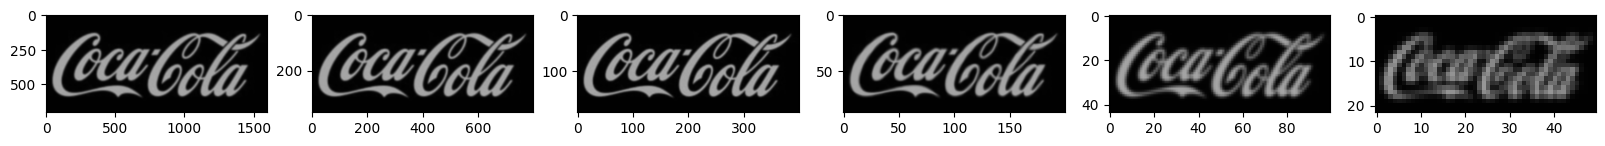

In [288]:
print("NUMBER OF TEMPLATES:", len(template_gauss_pyramid))

fig, axs = plt.subplots(nrows=1, ncols=len(template_gauss_pyramid))
fig.set_size_inches(20, 5)
for ax, template in zip(axs, template_gauss_pyramid):
    ax.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))

Para tener mayor granularidad se realizó una piramide con resize e interpolación con INTER_NEAREST.

In [289]:
def generate_template_pyramid(template, min_scale=0.05, max_scale=2.5, step=0.1):
    """Generate a pyramid with intermediate scales for a template."""
    height, width = template.shape[:2]
    pyramid = []
    scales = np.arange(min_scale, max_scale + step, step)  # Generate scale factors
    for scale in scales:
        resized = cv2.resize(template, None, fx=scale, fy=scale)
        pyramid.append(resized)
    return pyramid, scales

In [290]:
template_pyramid1, template_scales1 = generate_template_pyramid(template3, min_scale=0.2, max_scale=5, step=0.1)
template_pyramid2, template_scales2 = generate_template_pyramid(template4, min_scale=0.2, max_scale=5, step=0.1)
template_pyramid = template_pyramid1 + template_pyramid2
template_scales = template_scales1 + template_scales2
print("NUMBER OF TEMPLATES:", len(template_pyramid))

NUMBER OF TEMPLATES: 98


### Implementación de Non-Maximum Supression (NMS) con Intersection over Union (IoU)
Útil para gestionar la superposición de detecciones.

La métrica IoU se obtiene mediante la siguiente fórmula:

$IoU = \frac{\text{Area de intersección}}{\text{Área de unión}}$

In [291]:
def get_iou(box1, box2) -> float:
    """Get Intersection over Union metric for two given boxes"""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)

    # intersecion area
    intersection_width = max(0, xi2 - xi1)
    intersection_height = max(0, yi2 - yi1)
    intersection_area = intersection_width * intersection_height

    # union area
    area_box1 = w1 * h1
    area_box2 = w2 * h2
    union_area = area_box1 + area_box2 - intersection_area

    # IoU with safe zero division
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

NMS consiste en:
1. Obtener la caja con máximo score,
2. Calcular IoU de ella con el resto de las cajas
3. Filtrar las cajas IoU debajo de un threshold

In [292]:
def get_nms(boxes, scores, iou_threshold):
    """Non-Maximum Supression"""
    boxes_scores = sorted(zip(boxes, scores), key=lambda x: x[1], reverse=True)
    nms_boxes = []
    nms_scores = []
    while boxes_scores:
        max_box, max_score = boxes_scores.pop()
        nms_boxes.append(max_box)
        nms_scores.append(max_score)
        boxes_scores = [(box, score) for box, score in boxes_scores if get_iou(box, max_box) < iou_threshold]
    return nms_boxes, nms_scores

### Template matching
Consideraciones al comparar los resultados obtenidos para diferentes templates:
- Las metricas TM_CCOEF y TM_SQDIFF dependen del tamaño del template

In [293]:
# APPROACH #1
def single_template_matching(
    input_image,
    template_pyramid,
    metric_fn=cv2.TM_CCOEFF_NORMED,
    threshold=0.5,
    k_targets=1,
):
    preprocess_input = preprocess_image(input_image)
    detected_boxes = []
    detected_scores = []

    for template in template_pyramid:
        if (
            template.shape[0] > preprocess_input.shape[0]
            or template.shape[1] > preprocess_input.shape[1]
        ):
            continue
        match = cv2.matchTemplate(preprocess_input, template, metric_fn)
        _, max_value, _, max_loc = cv2.minMaxLoc(match)
        detected_boxes.append(
            [max_loc[0], max_loc[1], template.shape[1], template.shape[0]]
        )
        detected_scores.append(max_value)
    if not detected_scores:
        return [(-1, -1, -1, -1)]
    # Apply Non Maximum Suppression
    indices = cv2.dnn.NMSBoxes(detected_boxes, detected_scores, threshold, 0.2, top_k=k_targets)
    if len(indices) == 0:
        return [(-1, -1, -1, -1)]
    return [detected_boxes[index] for index in indices], [detected_scores[index] for index in indices], [template_pyramid[index] for index in indices]

Comparación de métodos de template matching haciendo un barrido por la pirámide de templates:

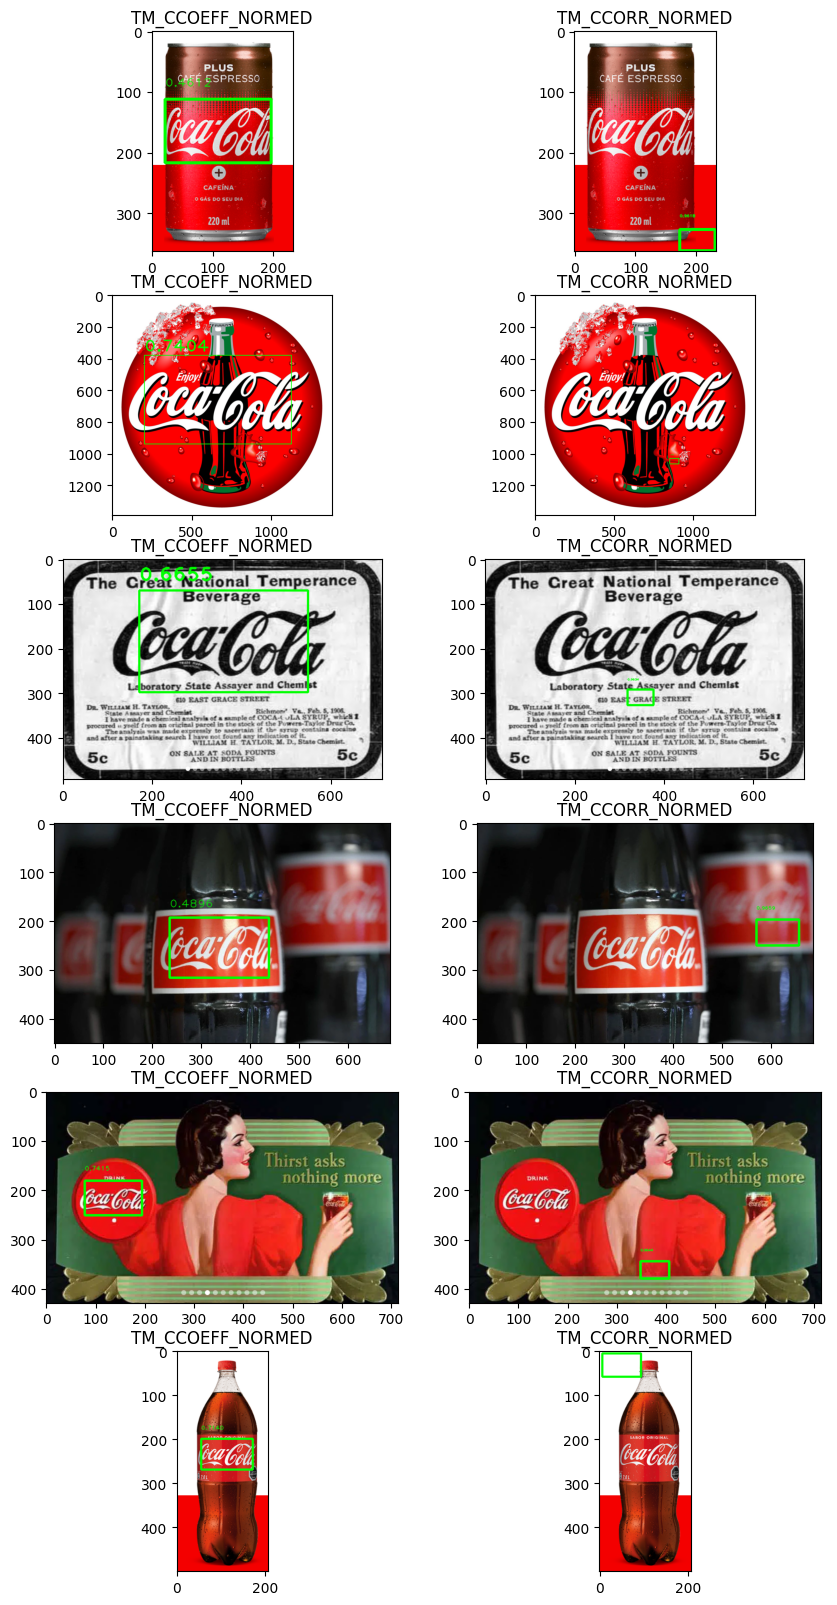

In [303]:
metrics = [
    # ("TM_CCOEFF", cv2.TM_CCOEFF),
    ("TM_CCOEFF_NORMED", cv2.TM_CCOEFF_NORMED, 0.37),
    # ("TM_CCORR", cv2.TM_CCORR),
    ("TM_CCORR_NORMED", cv2.TM_CCORR_NORMED, 0.95),
    # ("TM_SQDIFF", cv2.TM_SQDIFF), # no good results
    # ("TM_SQDIFF_NORMED", cv2.TM_SQDIFF_NORMED), # no good results
]

fig, axs = plt.subplots(nrows=len(input_images), ncols=len(metrics))
fig.set_size_inches(10, 20)

for input_image_idx, input_image in enumerate(images_color):
    for ax, (metric_name, metric_fn, threshold) in zip(axs[input_image_idx], metrics):
        boxes, scores, _ = single_template_matching(input_image.copy(), template_pyramid, metric_fn, threshold, k_targets=1)
        x, y, w, h = boxes[0]
        score = scores[0]

        plot_image = input_image.copy()
        cv2.rectangle(plot_image, (x, y), (x + w, y + h), (0, 255, 0), 3)
        cv2.putText(plot_image, f"{score:.4f}", (x, y-20), cv2.FONT_HERSHEY_PLAIN, w*0.008, (0, 255, 0), int(w*0.008), cv2.LINE_AA)
        ax.imshow(cv2.cvtColor(plot_image, cv2.COLOR_BGR2RGB))
        ax.set_title(metric_name)

Se puede observar que los mejores resultados se obtienen para el método `TM_CCOEFF_NORMED`, donde no hay falsos positivos.

In [295]:
# APPROACH #2
def multiple_template_matching(input_image, template, threshold = 0.5):
    preprocess_input = preprocess_image(input_image)
    h, w = template.shape
    match = cv2.matchTemplate(preprocess_input, template, cv2.TM_CCOEFF_NORMED)
    match_locations = np.where(match > threshold)
    detected_boxes = [(x, y, x + w, y + h) for x, y in zip(*match_locations[::-1])]
    detected_scores = [match[y, x] for x, y, _, _ in detected_boxes]
    nms_boxes, nms_scores = get_nms(detected_boxes, detected_scores, 0.3)
    if len(nms_boxes) == 0:
        return [(-1, -1, -1, -1)], [-1]
    return nms_boxes, nms_scores, match

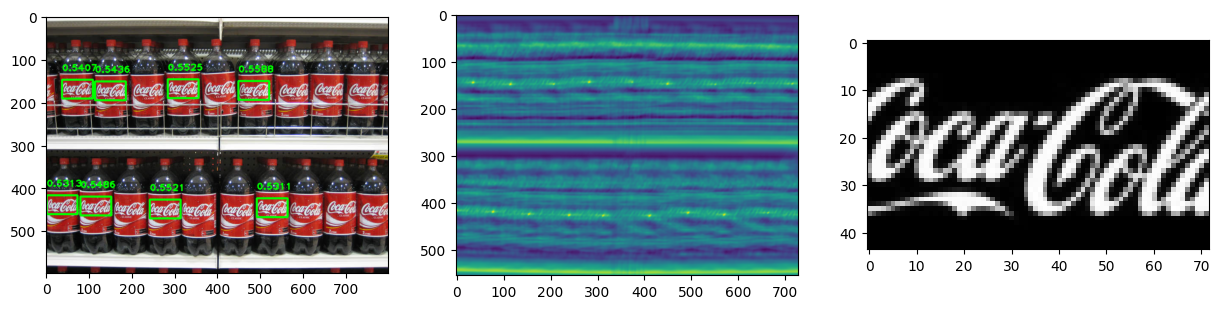

In [296]:
fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(15, 5)

input_image = cv2.imread(IMAGES_PATH + "coca_multi.png", cv2.IMREAD_COLOR)

template = cv2.resize(template4, None, fx=0.25, fy=0.25)
# detection_boxes, detection_scores, detection_templates = multiple_template_matching(input_image.copy(), template_pyramid[0], threshold=0.3)
detection_boxes, detection_scores, result = multiple_template_matching(input_image.copy(), template, threshold=0.53)
plot_image = input_image.copy()
for (x1, y1, x2, y2), score in zip(detection_boxes, detection_scores):
    # cv2.rectangle(plot_image, (x1, y1), (x + template.shape[1], y + template.shape[0]), (0, 255, 0), 3)
    cv2.rectangle(plot_image, (x1, y1), (x2, y2), (0, 255, 0), 3)
    cv2.putText(plot_image, f"{score:.4f}", (x1, y1-20), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2, cv2.LINE_AA)
axs[0].imshow(cv2.cvtColor(plot_image, cv2.COLOR_BGR2RGB))
axs[1].imshow(result)
axs[2].imshow(template, cmap="gray")

Se puede observar que se debe continuar trabajando en el tuning del algoritmo y el preprocesamiento de las imágenes.

### Generalización del algoritmo de template matching
Se desea obtener un algoritmo genérico para poder detectar logos en todas las imágenes de ejemplo.

In [297]:
# APPROACH #3
def template_matching(input_image, template_pyramid, threshold=0.5, iou_threshold=0.3):
    preprocess_input = preprocess_image(input_image)
    detected_boxes = []
    detected_scores = []
    for template in template_pyramid:
        h, w = template.shape
        if h > preprocess_input.shape[0] or w > preprocess_input.shape[1]:
            continue
        match = cv2.matchTemplate(preprocess_input, template, cv2.TM_CCOEFF_NORMED)
        match_locations = np.where(match > threshold)
        detected_boxes.extend(
            [(x, y, x + w, y + h) for x, y in zip(*match_locations[::-1])]
        )
        detected_scores.extend([match[y, x] for x, y in zip(*match_locations[::-1])])
    nms_boxes, nms_scores = get_nms(detected_boxes, detected_scores, iou_threshold)
    if len(nms_boxes) == 0:
        return [(-1, -1, -1, -1)], [-1]
    return nms_boxes, nms_scores

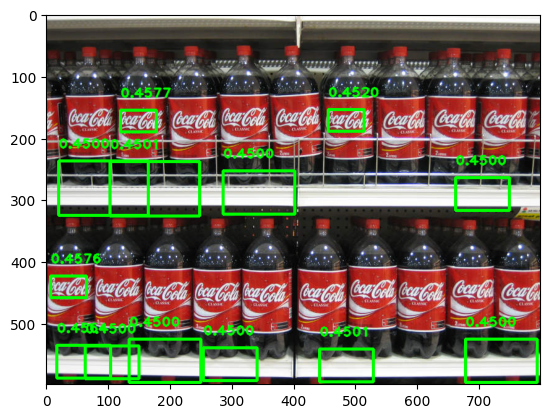

In [298]:
# algorithm
input_image = cv2.imread(IMAGES_PATH + "coca_multi.png", cv2.IMREAD_COLOR)
detection_boxes, detection_scores = template_matching(input_image.copy(), template_pyramid, threshold=0.45)

# results
plot_image = input_image.copy()
for (x1, y1, x2, y2), score in zip(detection_boxes, detection_scores):
    cv2.rectangle(plot_image, (x1, y1), (x2, y2), (0, 255, 0), 3)
    cv2.putText(plot_image, f"{score:.4f}", (x1, y1-20), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2, cv2.LINE_AA)
plt.imshow(cv2.cvtColor(plot_image, cv2.COLOR_BGR2RGB))

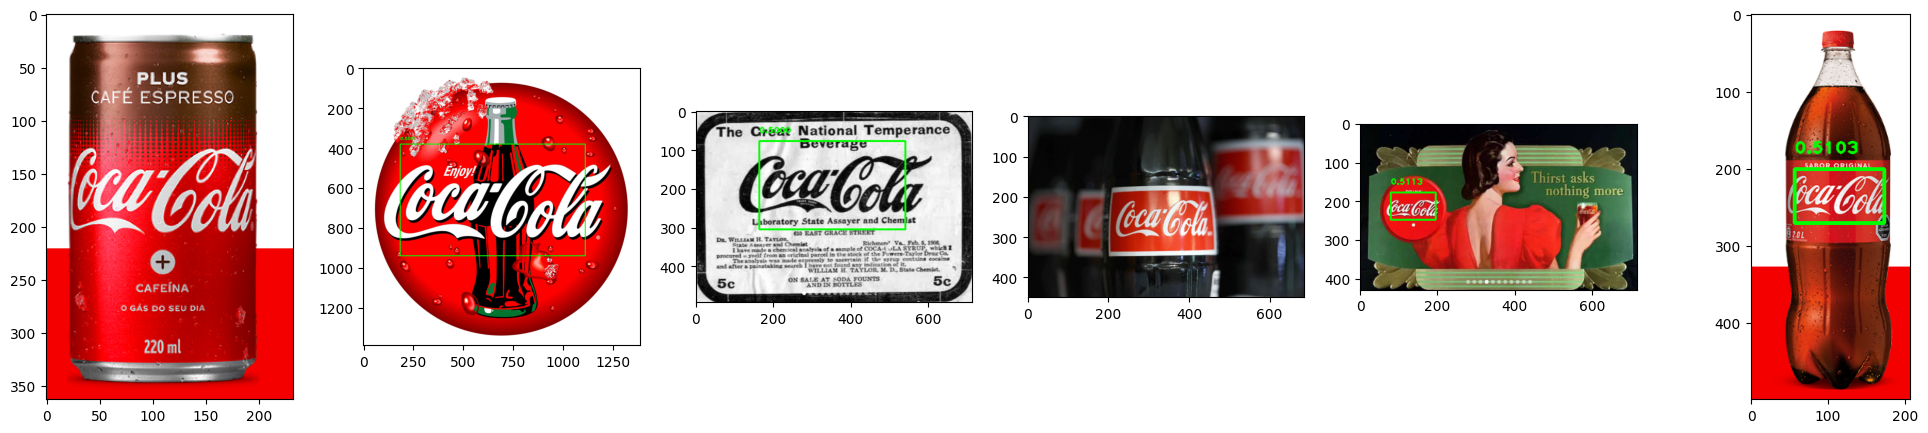

In [299]:
fig, axs = plt.subplots(nrows=1, ncols=len(images_color))
fig.set_size_inches(25, 5)

for ax, input_image in zip(axs, images_color):
    # algorithm
    detection_boxes, detection_scores = template_matching(input_image.copy(), template_pyramid, threshold=0.5, iou_threshold=0.1)

    # results
    plot_image = input_image.copy()
    for (x1, y1, x2, y2), score in zip(detection_boxes, detection_scores):
        cv2.rectangle(plot_image, (x1, y1), (x2, y2), (0, 255, 0), 3)
        cv2.putText(plot_image, f"{score:.4f}", (x1, y1-20), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2, cv2.LINE_AA)
    ax.imshow(cv2.cvtColor(plot_image, cv2.COLOR_BGR2RGB))

Se puede observar que hay dos entradas en las que algoritmo no pudo detectar el logo. Se necesita continuar trabajando en el tuning del algoritmo y el preprocesamiento de las entradas.

### Features matching con SIFT
Como parte de la experimentación para resolver el problema, se planteo el uso de SIFT para la detección de los logos de Coca-Cola.

Se obtuvo muy buenos resultados para las imágenes con un único logo.
El objetivo 1 fue cumplido: Obtener una detección del logo en cada imagen sin falsos positivos

A la hora de detectar múltiples logos en una misma imágen, se planteo el uso de DBSCAN para armar clústeres de las features matcheadas. No se obtuvo buenos resultados a la fecha de entrega.

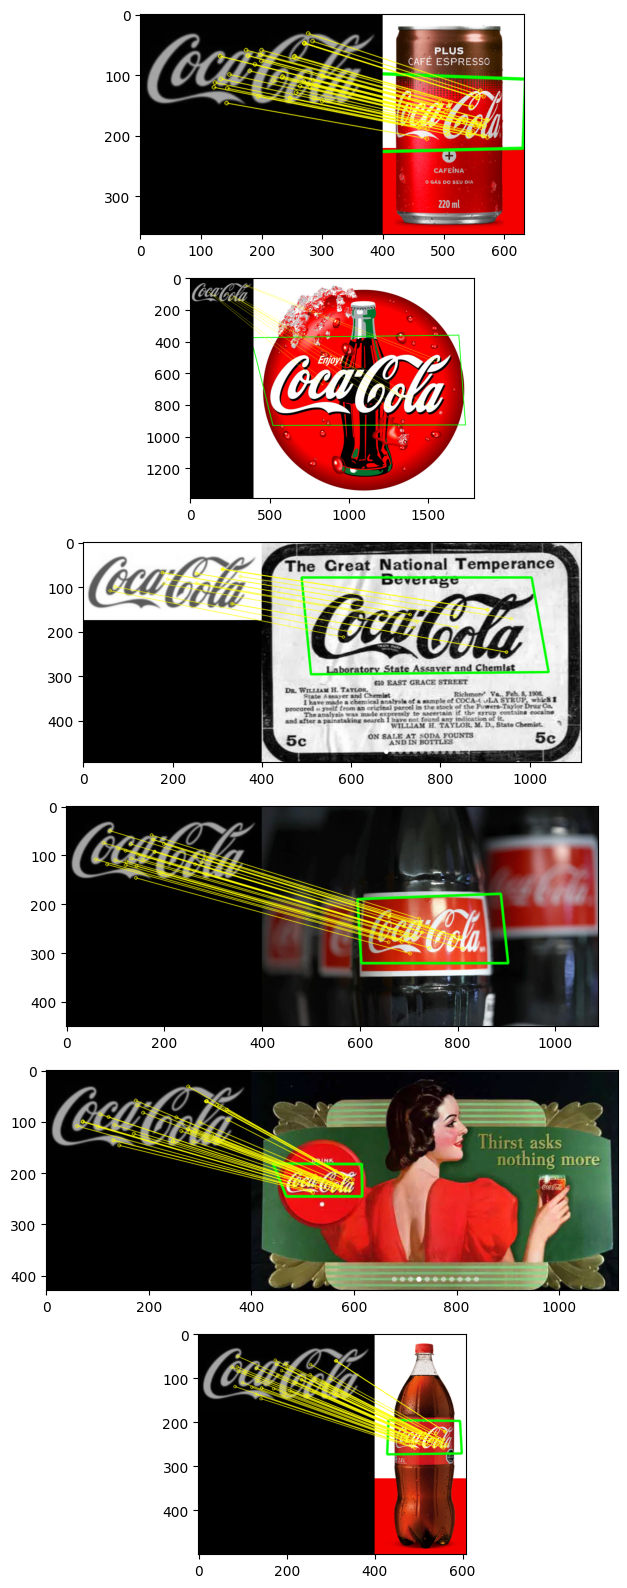

In [300]:
fig, axs = plt.subplots(nrows=len(input_images), ncols=1)
fig.set_size_inches(10, 20)

sift = cv2.SIFT_create()
bf_matcher = cv2.BFMatcher()

for input_image_idx, (ax, color_image, input_image) in enumerate(
    zip(axs, images_color, input_images)
):
    template = template2 if input_image_idx != 2 else template1
    keypoints_template, descriptors_template = sift.detectAndCompute(template, None)
    keypoints_input, descriptors_input = sift.detectAndCompute(input_image, None)
    matches = bf_matcher.knnMatch(descriptors_template, descriptors_input, k=2)

    good_matches = sorted(
        [m for m, n in matches if m.distance < 0.8 * n.distance],
        key=lambda x: x.distance,
    )
    template_points = np.float32(
        [keypoints_template[m.queryIdx].pt for m in good_matches]
    ).reshape(-1, 1, 2)
    input_points = np.float32(
        [keypoints_input[m.trainIdx].pt for m in good_matches]
    ).reshape(-1, 1, 2)

    homography, mask = cv2.findHomography(
        template_points, input_points, cv2.RANSAC, 3.0
    )
    draw_params = dict(
        matchColor=(0, 255, 255),
        singlePointColor=None,
        matchesMask=mask.ravel().tolist(),
        flags=2,
    )

    height, width = template.shape[:2]
    template_corners = np.float32(
        [[0, 0], [width, 0], [width, height], [0, height]]
    ).reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(template_corners, homography)

    plot_image = color_image.copy()
    plot_image = cv2.polylines(
        plot_image,
        [np.int32(transformed_corners)],
        isClosed=True,
        color=(0, 255, 0),
        thickness=3,
        lineType=cv2.LINE_AA,
    )
    plot_image = cv2.drawMatches(
        template,
        keypoints_template,
        plot_image,
        keypoints_input,
        good_matches,
        None,
        **draw_params
    )
    ax.imshow(cv2.cvtColor(plot_image, cv2.COLOR_BGR2RGB))

A continuación se puede observar que los puntos obtenidos para la imágen con múltiples targets a detectar es baja.

110
(< cv2.DMatch 0x75e3f7a14210>, < cv2.DMatch 0x75e3f7a156d0>)


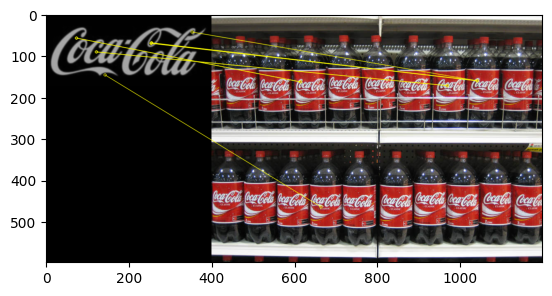

In [301]:
sift = cv2.SIFT_create()
bf_matcher = cv2.BFMatcher()
template = template2

color_image = cv2.imread(IMAGES_PATH + "coca_multi.png", cv2.IMREAD_COLOR)
input_image = preprocess_image(color_image)

keypoints_template, descriptors_template = sift.detectAndCompute(template, None)
keypoints_input, descriptors_input = sift.detectAndCompute(input_image, None)
matches = bf_matcher.knnMatch(descriptors_template, descriptors_input, k=2)
print(len(matches))
print(matches[0])

good_matches = sorted(
    [m for m, n in matches if m.distance < n.distance],
    key=lambda x: x.distance,
)

template_points = np.float32(
    [keypoints_template[m.queryIdx].pt for m in good_matches]
).reshape(-1, 1, 2)
input_points = np.float32(
    [keypoints_input[m.trainIdx].pt for m in good_matches]
).reshape(-1, 1, 2)

homography, mask = cv2.findHomography(
    template_points, input_points, cv2.RANSAC, 5.0
)
draw_params = dict(
    matchColor=(0, 255, 255),
    singlePointColor=None,
    matchesMask=mask.ravel().tolist(),
    flags=2,
)

plot_image = color_image.copy()
plot_image = cv2.drawMatches(
    template,
    keypoints_template,
    plot_image,
    keypoints_input,
    good_matches,
    None,
    **draw_params
)
plt.imshow(cv2.cvtColor(plot_image, cv2.COLOR_BGR2RGB))


Y como es esperado dado el resultado anterior, no se detectan correctamente los targets.

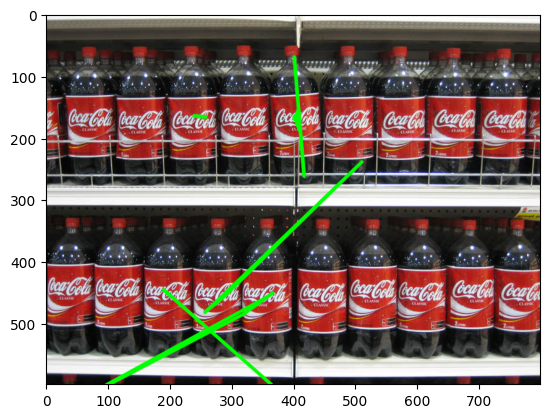

In [302]:
input_points = np.float32(
    [keypoints_input[m.trainIdx].pt for m in good_matches]
)

# Cluster matches
dbscan = DBSCAN(eps=30, min_samples=4).fit(input_points)
labels = dbscan.labels_

# Separate matches into groups
unique_labels = set(labels)
clusters = {label: [] for label in unique_labels if label != -1}

for match, label in zip(good_matches, labels):
    if label != -1:  # Exclude noise points
        clusters[label].append(match)

detections = []
for label, cluster_matches in clusters.items():
    template_points = np.float32([keypoints_template[m.queryIdx].pt for m in cluster_matches]).reshape(-1, 1, 2)
    input_points = np.float32([keypoints_input[m.trainIdx].pt for m in cluster_matches]).reshape(-1, 1, 2)
    
    # Compute homography for this group
    homography, mask = cv2.findHomography(template_points, input_points, cv2.RANSAC, 5.0)
    if homography is not None:
        # Transform template corners
        height, width = template.shape[:2]
        template_corners = np.float32([[0, 0], [width, 0], [width, height], [0, height]]).reshape(-1, 1, 2)
        transformed_corners = cv2.perspectiveTransform(template_corners, homography)
        detections.append(transformed_corners)


plot_image = color_image.copy()
for corners in detections:
    cv2.polylines(
        plot_image,
        [np.int32(corners)],
        isClosed=True,
        color=(0, 255, 0),
        thickness=3,
        lineType=cv2.LINE_AA,
    )

plt.imshow(cv2.cvtColor(plot_image, cv2.COLOR_BGR2RGB))

### Recursos
- [Image Processing in OpenCV: Template matching](https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html)
- [Image Processing: Image Pyramids](https://docs.opencv.org/4.x/d4/d1f/tutorial_pyramids.html)
- [2D Features framework: Basic concepts of the homography explained with code](https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html)